In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

from pmesh.pm import ParticleMesh
from nbodykit.lab import BigFileCatalog, BigFileMesh, FFTPower, MultipleSpeciesCatalog

# sys.path.append('../code/utils/')
# import tools, dohod
from time import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib.colors import LogNorm, SymLogNorm

# Cleaning


In [3]:
dpath = '/project/projectdirs/m3127/H1mass/'
# dpath = '../data/'

bs, nc = 256, 256
# sim = '/lowres/%d-9100-fixed'%256
sim = '/highres/%d-9100-fixed'%2560
aafiles = [0.1429, 0.1538, 0.1667, 0.1818, 0.2000, 0.2222, 0.2500, 0.2857, 0.3333]
atoz = lambda a: 1/a -1
zzfiles = [round(atoz(aa), 2) for aa in aafiles]

aa = 0.3333
halos = BigFileCatalog(dpath + sim+ '/fastpm_%0.4f/halocat/'%aa)
cen = BigFileCatalog(dpath + sim+ '/fastpm_%0.4f/cencat/'%aa)
sat = BigFileCatalog(dpath + sim+ '/fastpm_%0.4f/satcat-m1_5p0min-alpha_0p9/'%aa)
hmass, h1mass = halos["Mass"].compute(), halos['H1mass'].compute()
cmass, ch1mass = cen["Mass"].compute(), cen['H1mass'].compute()
smass, sh1mass = sat["Mass"].compute(), sat['H1mass'].compute()
hpos, cpos, spos = halos['Position'].compute(), cen['Position'].compute(), sat['Position'].compute()
chid, shid = cen['HaloID'].compute(), sat['HaloID'].compute()



In [7]:
zzfiles

[6.0, 5.5, 5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0]

In [8]:
bs = 256
nc = 256
pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc])

In [9]:
dm = BigFileMesh('/global/project/projectdirs/m3127/H1mass/highres/2560-9100-fixed/fastpm_0.1429/dmesh_N0256', '1').paint()
meshpos = pm.paint(hpos)
mesh = pm.paint(hpos, mass=hmass)
meshposnn = pm.paint(hpos, resampler='nearest')
meshnn = pm.paint(hpos, mass=hmass, resampler='nearest')


In [10]:
cmesh = meshnn.r2c()
mask = [np.ones_like(ki) for ki in cmesh.x]
mask[2] *= abs(cmesh.x[2]) > 0.1
mask = prod(mask)
cmesh *= mask
mesh2 = cmesh.c2r()
mesh3 = cmesh.apply(lambda k, v: v*np.exp(-sum(ki**2 for ki in k)*1**2)).c2r()

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


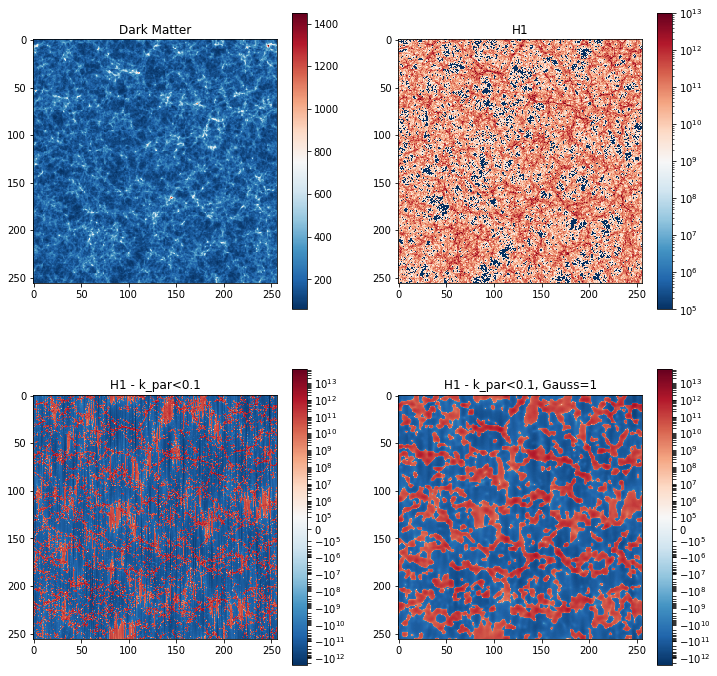

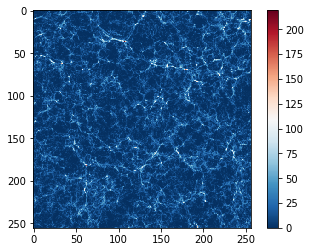

In [12]:
norm = LogNorm(1e5, 1e13)
# norm = None
x1, x2 = 5, 10
cmap = 'RdBu_r'

fig, ax = plt.subplots(2, 2, figsize = (12, 12))
im = ax[0, 0].imshow(dm[...][x1:x2, :, :].sum(axis=0).T, cmap=cmap)
plt.colorbar(im, ax=ax[0, 0])
ax[0, 0].set_title('Dark Matter')
im = ax[0, 1].imshow(1+meshnn[...][x1:x2, :, :].sum(axis=0).T, norm=norm, cmap=cmap)
plt.colorbar(im, ax=ax[0, 1])
norm = SymLogNorm(1e5)
ax[0, 1].set_title('H1')
im = ax[1, 0].imshow(1+mesh2[...][x1:x2, :, :].sum(axis=0).T, norm=norm, cmap=cmap)
plt.colorbar(im, ax=ax[1, 0])
ax[1, 0].set_title('H1 - k_par<0.1')
im = ax[1, 1].imshow(1+mesh3[...][x1:x2, :, :].sum(axis=0).T, norm=norm, cmap=cmap)
plt.colorbar(im, ax=ax[1, 1])
ax[1, 1].set_title('H1 - k_par<0.1, Gauss=1')
plt.show()
im = plt.imshow(meshposnn[...][x1:x2, :, :].sum(axis=0).T, cmap=cmap)
plt.colorbar(im)

In [13]:
hpos[0]/bs*nc

array([23.932821, 62.835903, 25.79345 ], dtype=float32)

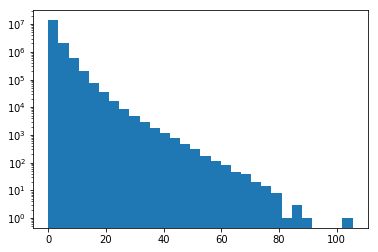

In [14]:
plt.hist(meshpos[...].flatten(), bins=30, log=True)
plt.show()

In [15]:
p1 = FFTPower(mesh/mesh.cmean(), mode='1d').power
p2 = FFTPower(mesh2/mesh.cmean(), mode='1d').power
p3 = FFTPower(mesh3/mesh.cmean(), mode='1d').power
p13 = FFTPower(mesh/mesh.cmean(), second=mesh3/mesh.cmean(), mode='1d').power

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(1, 100000.0)

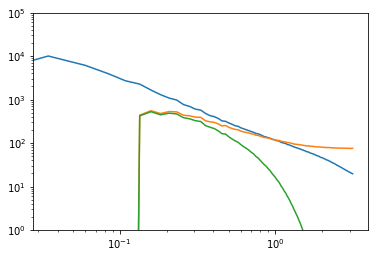

In [16]:
plt.loglog(p1['k'], p1['power'])
plt.loglog(p1['k'], p2['power'])
plt.loglog(p1['k'], p3['power'])
plt.ylim(1, 1e5)

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


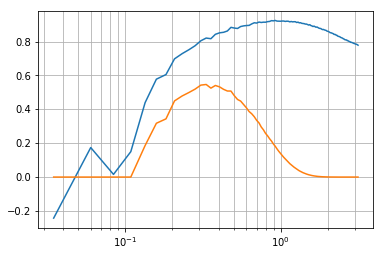

In [17]:
plt.semilogx(p1['k'], p13['power']*(p3['power']*p1['power'])**-0.5)
plt.semilogx(p1['k'], (p3['power']/p1['power'])**1)
plt.grid(which='both')
plt.show()

In [18]:
xx = np.log10(1+mesh[...].flatten())
yy = np.log10(1+mesh3[...].flatten())
yy2 = np.log10((1-mesh3[...]).flatten())

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


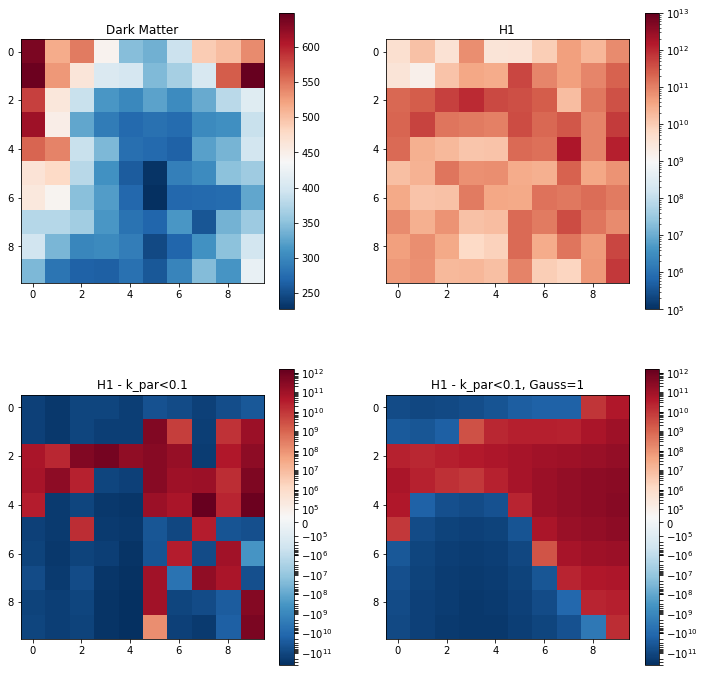

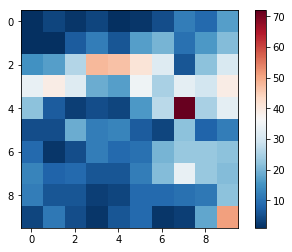

In [19]:
norm = LogNorm(1e5, 1e13)
# norm = None
x1, x2 = 5, 15
y1, y2 = 5, 15
z1, z2 = 5, 15
cmap = 'RdBu_r'

fig, ax = plt.subplots(2, 2, figsize = (12, 12))
im = ax[0, 0].imshow(dm[...][x1:x2, y1:y2, z1:z2].sum(axis=0).T, cmap=cmap)
plt.colorbar(im, ax=ax[0, 0])
ax[0, 0].set_title('Dark Matter')
im = ax[0, 1].imshow(1+meshnn[...][x1:x2, y1:y2, z1:z2].sum(axis=0).T, norm=norm, cmap=cmap)
plt.colorbar(im, ax=ax[0, 1])
norm = SymLogNorm(1e5)
ax[0, 1].set_title('H1')
im = ax[1, 0].imshow(1+mesh2[...][x1:x2, y1:y2, z1:z2].sum(axis=0).T, norm=norm, cmap=cmap)
plt.colorbar(im, ax=ax[1, 0])
ax[1, 0].set_title('H1 - k_par<0.1')
im = ax[1, 1].imshow(1+mesh3[...][x1:x2, y1:y2, z1:z2].sum(axis=0).T, norm=norm, cmap=cmap)
plt.colorbar(im, ax=ax[1, 1])
ax[1, 1].set_title('H1 - k_par<0.1, Gauss=1')
plt.show()
im = plt.imshow(meshposnn[...][x1:x2, y1:y2, z1:z2].sum(axis=0).T, cmap=cmap)
plt.colorbar(im)

In [20]:
(meshposnn[...][x1:x2, y1:y2, z1:z2] == 0).sum()

550

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


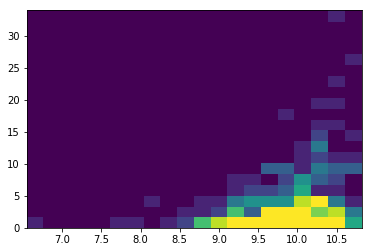

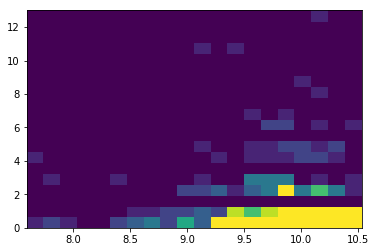

In [21]:
xx = np.log10(mesh3[...][x1:x2, y1:y2, z1:z2].flatten())
xxm = np.log10(-mesh3[...][x1:x2, y1:y2, z1:z2].flatten())
yy= meshposnn[...][x1:x2, y1:y2, z1:z2].flatten()
# plt.scatter(xx, yy)
mask = ~np.isnan(xx)
plt.hist2d(xx[mask], yy[mask], vmin=0, vmax=10, bins=20)
plt.show()
mask = np.isnan(xx)
im = plt.hist2d(xxm[mask], yy[mask], vmin=0, vmax=10, bins=20)
plt.show()

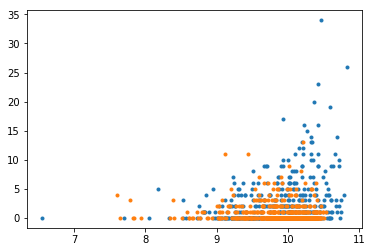

In [22]:
plt.plot(xx, yy, '.')
plt.plot(xxm, yy, '.')


# Checkfiles


In [4]:
atoz(0.25)

3.0

In [109]:
# halocat = BigFileCatalog('/project/projectdirs/m3127/21cm_cleaning/lowres/256-9100-fixed/fastpm_0.2500/halocat/')
# h1mesh = BigFileMesh('/project/projectdirs/m3127/21cm_cleaning/lowres/256-9100-fixed/fastpm_0.2500/H1mesh_N0256', 'H1').paint()
# kparmesh = BigFileMesh('/project/projectdirs/m3127/21cm_cleaning/lowres/256-9100-fixed/fastpm_0.2500/H1mesh_N0256', 'kpar0p1').paint()
# kpargmesh = BigFileMesh('/project/projectdirs/m3127/21cm_cleaning/lowres/256-9100-fixed/fastpm_0.2500/H1mesh_N0256', 'kpar0p1-R1p0').paint()

halocat = BigFileCatalog('/project/projectdirs/m3127/21cm_cleaning/highres/2560-9100-fixed/fastpm_0.1429/halocat-1/')
h1mesh = BigFileMesh('/project/projectdirs/m3127/21cm_cleaning/highres/2560-9100-fixed/fastpm_0.1429/HImesh_N0256-1', 'HI').paint()
kparmesh = BigFileMesh('/project/projectdirs/m3127/21cm_cleaning/highres/2560-9100-fixed/fastpm_0.1429/HImesh_N0256-1', 'kpar0p1').paint()
kpargmesh = BigFileMesh('/project/projectdirs/m3127/21cm_cleaning/highres/2560-9100-fixed/fastpm_0.1429/HImesh_N0256-1', 'kpar0p1-R1p0').paint()

halocat2 = BigFileCatalog('/project/projectdirs/m3127/21cm_cleaning/highres/2560-9100-fixed/fastpm_0.1429/halocat/')
h1mesh2 = BigFileMesh('/project/projectdirs/m3127/21cm_cleaning/highres/2560-9100-fixed/fastpm_0.1429/HImesh_N0256', 'HI').paint()
kparmesh2 = BigFileMesh('/project/projectdirs/m3127/21cm_cleaning/highres/2560-9100-fixed/fastpm_0.1429/HImesh_N0256', 'kpar0p1').paint()
kpargmesh2 = BigFileMesh('/project/projectdirs/m3127/21cm_cleaning/highres/2560-9100-fixed/fastpm_0.1429/HImesh_N0256', 'kpar0p1-R1p0').paint()


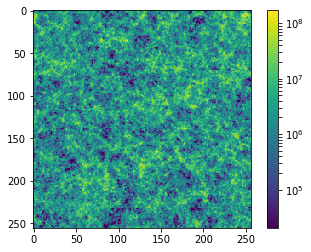

In [110]:
x1, x2 = 5, 15
norm = LogNorm(1e7, 1e10)
norm = SymLogNorm(1e5)
im = plt.imshow(1+h1mesh[x1:x2,...].sum(axis=0).T, norm=norm)
plt.colorbar(im)

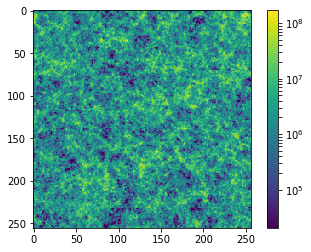

In [111]:
x1, x2 = 5, 15
norm = LogNorm(1e7, 1e10)
norm = SymLogNorm(1e5)
im = plt.imshow(1+h1mesh2[x1:x2,...].sum(axis=0).T, norm=norm)
plt.colorbar(im)

In [116]:
h1mesh2 /h1mesh;

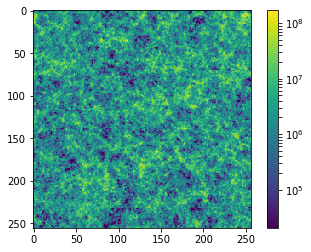

In [117]:
x1, x2 = 5, 15
norm = LogNorm(1e7, 1e10)
norm = SymLogNorm(1e5)
im = plt.imshow(1+h1mesh2[x1:x2,...].sum(axis=0).T, norm=norm)
plt.colorbar(im)

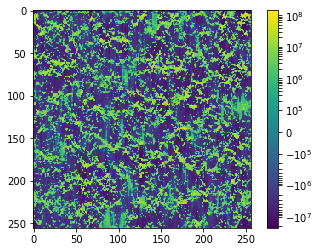

In [118]:
norm = LogNorm(1e7, 1e10)
norm = SymLogNorm(1e5)
im = plt.imshow(1+kparmesh2[x1:x2,...].sum(axis=0).T, norm=norm)
plt.colorbar(im)

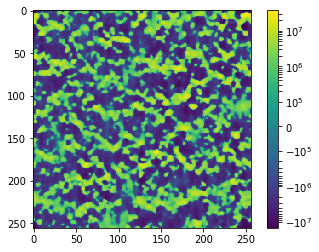

In [119]:
norm = LogNorm(1e1, 1e10)
norm = SymLogNorm(1e5)
im = plt.imshow(1+kpargmesh2[x1:x2,...].sum(axis=0).T, norm=norm)
plt.colorbar(im)

In [94]:
mesh = halocat.to_mesh(BoxSize=bs,Nmesh=[nc,nc,nc], position='Position',value='HImass' ) 

In [95]:
tmp=mesh.to_real_field()

In [139]:
tmp = np.load('/global/cscratch1/sd/chmodi/m3127/21cm_cleaning/highres/2560-9100-fixed/fastpm_0.2500/voxels-256/mesh-kpar0p1-R1p0-0000.f4.npy')
# tmp = np.load('/global/cscratch1/sd/chmodi/m3127/21cm_cleaning/highres/2560-9100-fixed/fastpm_0.3333/voxels-256/mesh-kpar0p1-R1p0-0005.f4.npy')

In [140]:
tmp.shape

(256, 256, 256, 3)

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/image.py:865: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


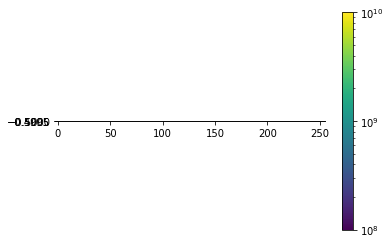

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/matplotlib/colors.py:1143: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > (self.linthresh * self._linscale_adj)


ValueError: arange: cannot compute length

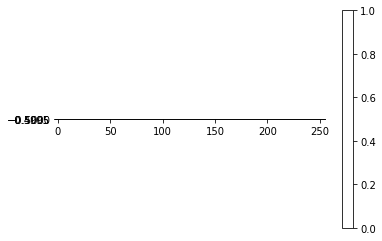

In [135]:
x1, x2 = 5, 10
norm = LogNorm(1e8, 1e10)
im = plt.imshow(tmp[x1:x2,...,0].sum(axis=0).T, norm=norm)
plt.colorbar(im)
plt.show()
norm = SymLogNorm(1e5)
im = plt.imshow(tmp[x1:x2,...,1].sum(axis=0).T, norm=norm)
plt.colorbar(im)
plt.show()
norm = SymLogNorm(1e5)
im = plt.imshow(tmp[x1:x2,...,2].sum(axis=0).T, norm=norm)
plt.colorbar(im)
plt.show()

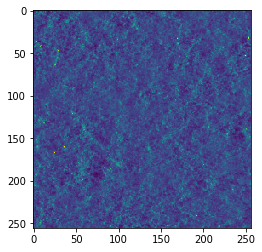

In [126]:
plt.imshow(tmp[...,1].sum(axis=0))

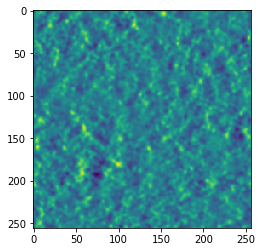

In [127]:
plt.imshow(tmp[...,2].sum(axis=0))